In [16]:
import torch
import torch.nn.functional as F
#from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch import nn
#import pandas as pd
#import pyarrow as pa
from torch.optim import Adam
import numpy as np
import os

import matplotlib.pyplot as plt

In [2]:
current_dir = os.getcwd()

In [3]:
label_files = os.path.join(current_dir, 'labels')
vector_files = os.path.join(current_dir, 'vectors')

label_list = []
vector_list =[]

i = 0
for filename in os.listdir(vector_files):
    file_path = os.path.join(vector_files, filename)
    vector_list.append(torch.load(file_path).detach())
    i+=1
    

j = 0
for filename in os.listdir(label_files):
    if j <= i:
        file_path = os.path.join(label_files, filename)
        label_list.append(torch.load(file_path).detach())
        j+=1
    else:
        break
    
    

In [34]:
# Converts the labels and the bert output for each row into a tensor
labels = torch.cat(label_list).float()
final_pool = torch.cat(vector_list).float()


# Divide all the labels by 4 so that they're in range [0,1]
labels /= 4

labels -= .5

labels = torch.clip(labels, min=0, max=1)
labels = torch.sign(labels)

# Set up a standard scaler
scaler = StandardScaler()

# Fit the scaler to our data
scaler.fit(final_pool)

# Transform our data using the scaler
normalized_values = scaler.transform(final_pool)

In [35]:
final_pool.shape

torch.Size([5008, 768])

In [36]:
labels[:10]

tensor([0., 0., 1., 1., 1., 1., 1., 1., 0., 1.])

In [37]:
from sklearn.decomposition import PCA

In [38]:
pca = PCA(2)

In [39]:
low_embed = pca.fit_transform(normalized_values)

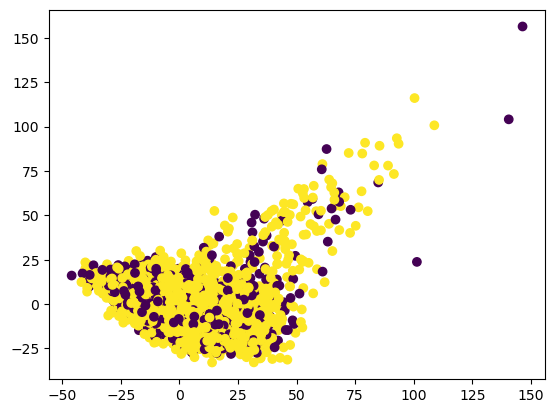

In [40]:
plt.scatter(*low_embed.T, c=labels.numpy())

In [73]:
# convert our data into a torch dataset
#need y data from the file
ratings = torch.tensor(labels).float()
#print(labels[5])
# Add a validation set
x_train, x_test, y_train, y_test = train_test_split(normalized_values, ratings, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)


# Data processing
data = torch.utils.data.TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float())
test_data = torch.utils.data.TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float())

# set up a data loader to get batches from our dataset
loader = torch.utils.data.DataLoader(data, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 128, shuffle = True)

/tmp/ipykernel_2368225/1809373931.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ratings = torch.tensor(labels).float()
/tmp/ipykernel_2368225/1809373931.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.utils.data.TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float())
/tmp/ipykernel_2368225/1809373931.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.utils.data.TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float())


In [74]:
model = torch.nn.Sequential(   
    torch.nn.Linear(768,800),
    torch.nn.SiLU(),
    torch.nn.Linear(800,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,16),
    torch.nn.SiLU(),
    torch.nn.Linear(16,1)
)
# Figure out whether its coming from sigmoid, loss function, or something else 

In [75]:
scoring_function = torch.nn.BCEWithLogitsLoss(reduce=False, reduction='none')

num_epochs = 1000

optimizer = torch.optim.Adam( model.parameters(), .001 )

/home/cory/anaconda3/envs/geom_ml/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [76]:
def train():  
    epoch_losses = []

    for batch in loader:

        optimizer.zero_grad()

        # prepare the input and output tensors for the current batch
        batchX = torch.tensor(batch[0], dtype=torch.float32)
        batchY = torch.tensor(batch[1], dtype=torch.float32)
        batchY = batchY.unsqueeze(1)

        # forward pass
        y_pred = model.forward(batchX)

        #print(y_pred)
        #print(batchY)
        #print(batchX)
        #print(batchX.shape)




        # Compute the loss
        loss = scoring_function(y_pred, batchY)

        epoch_losses.append(loss)

        # Compute the gradient of the error with respect to the model parameters
        loss.mean().backward()

        # update the model parameters
        optimizer.step()

        # print the epoch and the average error for the epoch
    all_epoch_loss = torch.cat(epoch_losses)
    return all_epoch_loss    
        
        
            

In [77]:
for epoch in range(num_epochs):
    ep_result = train()
    print('Epoch {}, Average Error: {}'.format(epoch, ep_result.mean()))

/tmp/ipykernel_2368225/3228352928.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batchX = torch.tensor(batch[0], dtype=torch.float32)
/tmp/ipykernel_2368225/3228352928.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batchY = torch.tensor(batch[1], dtype=torch.float32)


Epoch 0, Average Error: 0.671214759349823
Epoch 1, Average Error: 0.6067714095115662
Epoch 2, Average Error: 0.6006098985671997
Epoch 3, Average Error: 0.6001118421554565
Epoch 4, Average Error: 0.5995932221412659
Epoch 5, Average Error: 0.5978721380233765
Epoch 6, Average Error: 0.5930480360984802
Epoch 7, Average Error: 0.5955328941345215
Epoch 8, Average Error: 0.6001460552215576
Epoch 9, Average Error: 0.5952704548835754
Epoch 10, Average Error: 0.5917606353759766
Epoch 11, Average Error: 0.5872975587844849
Epoch 12, Average Error: 0.5834764838218689
Epoch 13, Average Error: 0.5774585604667664
Epoch 14, Average Error: 0.5819754600524902
Epoch 15, Average Error: 0.5719725489616394
Epoch 16, Average Error: 0.5635440945625305
Epoch 17, Average Error: 0.5522390007972717
Epoch 18, Average Error: 0.560084342956543
Epoch 19, Average Error: 0.5429815053939819
Epoch 20, Average Error: 0.5386541485786438
Epoch 21, Average Error: 0.5330687761306763
Epoch 22, Average Error: 0.5203391313552856


KeyboardInterrupt: 

In [78]:
def transform_prediction_to_target_format(num):
    """if 0.0 <= num and num < 0.2:
        return 0
    if 0.2 <= num and num < 0.4:
        return 0.25
    if 0.4 <= num and num < 0.6:
        return 0.5
    if 0.6 <= num and num < 0.8:
        return 0.75
    if 0.8 <= num and num <=1:
        return 1"""
    if num > 0.5:
        return 1
    else:
        return 0

In [79]:
itemized_predictions = []
# Set the model to evaluation mode
model.eval()

# Iterate over the test set and collect the model's predictions
predictions = []
for batch in test_loader:
    batch_input_ids = batch[0]
    #batch_attention_masks = batch[1]
    batch_labels = batch[1]

    with torch.no_grad():
        outputs = model(batch_input_ids)

    logits = outputs
    for each in logits:
        pred = torch.sigmoid(each)
        itemized_predictions.append(transform_prediction_to_target_format(pred))
    # print(logits)
    # print(torch.sigmoid(logits))
    #batch_predictions = torch.argmax(logits, dim=None).tolist()
    #print(batch_predictions)
    #predictions.extend(batch_predictions)

# Calculate the accuracy on the test set
correct_predictions = 0
for i in range(len(itemized_predictions)):
    #print(f"Itemized prediction: {itemized_predictions[i]}")
    #print(f"Actual target: {y_test[i]}")
    if itemized_predictions[i] == y_test[i]:
        correct_predictions += 1

accuracy = correct_predictions / len(y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6227544910179641


In [80]:
# Take the full dataset, PCA it down to 2 dimensions, view it as colored by group 

In [81]:
first_3_layers = model[:5]
first_3_layers

Sequential(
  (0): Linear(in_features=768, out_features=800, bias=True)
  (1): SiLU()
  (2): Linear(in_features=800, out_features=64, bias=True)
  (3): SiLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
)

In [82]:
layer3embeds = first_3_layers(torch.tensor(x_train).float())

In [83]:
layer3embeds.shape

torch.Size([4056, 64])

In [84]:
newPCA = PCA(2)
newScaler = StandardScaler()

In [85]:
pca_of_layer3 = newPCA.fit_transform(newScaler.fit_transform(layer3embeds.detach().numpy()))

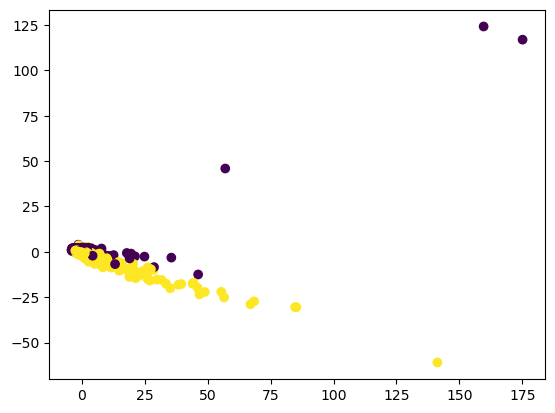

In [86]:
plt.scatter(pca_of_layer3[:, 0], pca_of_layer3[:,1], c=y_train)
#plt.xlim(-5, 75)
#plt.ylim(-20,10)